# Example usage

The main tool in fractrics is the MSM class, an implementation of the univariate [Markov Switching Multifractal Model](https://en.wikipedia.org/wiki/Markov_switching_multifractal). The logaritmic difference between observations is modeled as the noise-adjusted square root of the product of a chosen number of latent volatility components, each following the dynamics of discrete first order markov chains, whose transition depends on geometrically-spaced Poisson arrivals, and an unconditional term, effectively being the unconditional volatility.

Such structure effectively captures the behaviour of time series with fat tails, hyperbolic correlation decay, and multifractal moments, such as the returns of many financial assets.

The implementation is made in JAX, thus leveraging JIT compilation while keeping the simple syntax of python.

To use the model, we start by simulating data from a MSM process.
In this package, we adopt a functional style, where methods are free functions (under the `MSM` namespace), while relevant information about the model (data, hyperparameters, parameters, ...) are kept in a `metadata` object, which is the primary input for most of the functions of the package.

To make a simulation, we need to initialize hyperparameters and parameters of the model in the `metadata`. It requires the following hyperparameters:
 - `n_latent`: how many volatility components, integer.
 - `marg_prob_mass`: the probability mass of the marginal distribution of the latent states, needs to sum to 1.

By assumption, all the parameters need to be positive, and have further individual constrains:

- `marg_value`: One of the values of the support of the marginal probability mass defined in the parameters. The marginal probability mass needs to have unity and positive support. In the symmetric binomial case, this can be enforced by specifying one value $m_0$, and having the second value be $2 - m_0$, which is the case that this implementation focuses on. More general marginal distributions could be considered, but then the computations of standard errors may become more challenging, because the unity and positivity constraints impose dependencies on the Hessian matrix, thus making hypothesis tests impossible. 

- `unconditional_term`: the unconditional distribution of the model, a positive double.

- `arrival_gdistance`: the geometric distance between the Poisson arrivals of each latent volatility component, a positive double.

- `hf_arrival`: the highest poisson arrival probability (i.e. the proability of state switch of the highest frequency component).


In [1]:
import jax.numpy as jnp
from fractrics import MSM

model = MSM.metadata(data=None,
    parameters= {
    'unconditional_term': 1.0,
    'arrival_gdistance': 3.0,
    'hf_arrival': 0.98,
    'marginal_value': 1.5 
    },
    
    num_latent= 5)

The `MSM.simulation` method takes a `msm_metadata` object as input to choose the parameters.

Follows an example with the parameters of the fitted model above. It returns a tuple containing the simulated logarithmic change (e.g. 1 step return in a financial setting) and corresponding implied volatility.

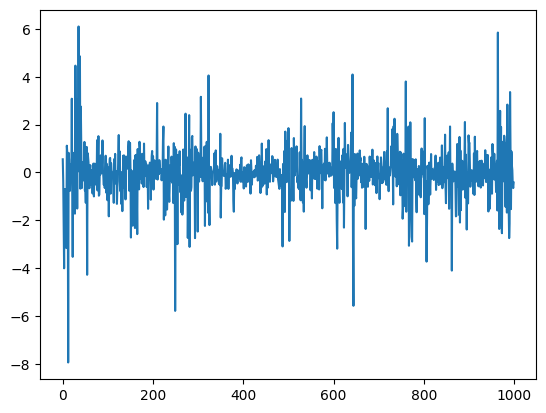

In [2]:
import matplotlib.pyplot as plt
ret, vol = MSM.simulation(n_simulations = 1000, model_info = model, seed=123)
plt.plot(ret)
plt.show()

To fit the model to the data, start with an initial guess. The `MSM.fit()` method then optimizes the parameters using a custom implementation of the [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), and the constrains are enforced with an internal re-mappig. 

Note that the model is only defined for positive time series (as it was created to model prices of financial assets), so we reconstruct the price from `ret`.

In [3]:
from dataclasses import replace
x = jnp.exp(jnp.cumsum(ret))
model = replace(model, data=x)
msm_result = MSM.fit(model, max_iter=1000)

`msm_result` is also `msm_metadata` that contains relevant information about the model. This construct reduces the verbosity of the API, as it can be passed as the only input required to operate with the following methods.

It contains:
- `filtered`: a dictionary containing the current distribution of the latent components, the list of distribution list at each time step, inferred using the forward algorithm, the transition tensor of the model (in factor form), and the vector of latent states (which can be populated using the `MSM.filter()` method.)
- `parameters`: a dictionary containing the model parameters.
- `standard_errors`: a dictionary containing the model standard errors
- `robust_standard_errors`: a dictionary containing the [Eicker–Huber–White](https://en.wikipedia.org/wiki/Heteroskedasticity-consistent_standard_errors) standard errors
- `num_latent:` the number of latent volatility components. 
- `optimization_info`: information about the optimization process
- `name`: the internal name of the model (defaults to "MSM")
- `data`: the input data
- `data_log_change`: the logarithmic change between each data point and its next observation (e.g. the log. return if the original data is a series of financial prices).

Most of this information can be printed using the `summary()` function.

In [4]:
from fractrics.utilities import summary
summary(msm_result)

                    parameters standard_errors robust_standard_errors
unconditional_term   1.4911367      0.11745711             0.13154256
arrival_gdistance      6.67688             nan              4.2458887
hf_arrival          0.02006583     0.017231423            0.019555239
marginal_value       1.6799235      0.02701448            0.028021006
negative_log_likelihood    -1467.5436
n_iteration                       161
is_converged                     True
dtype: object


Finally, a 200 period forecast. The method returns the (noise-free) expected state at each forecast horizon, along with selected confidence intervals.

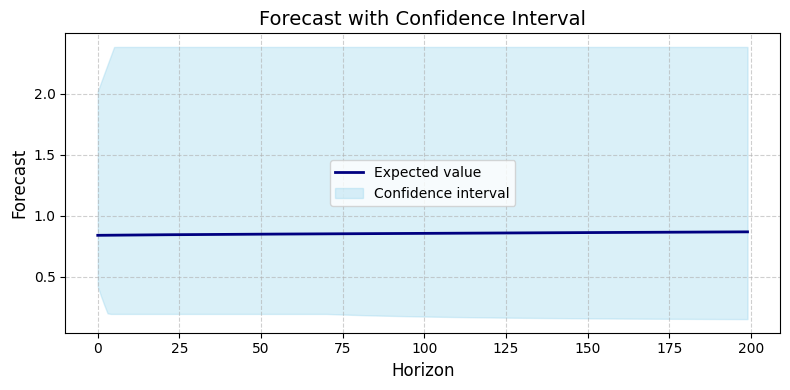

In [5]:
filtered = MSM.filter(msm_result)
expect, c1, c2 = MSM.forecast(horizon=200, model_info=filtered, quantiles=(0.05, 0.95))
from fractrics.utilities import plot_forecast
plot_forecast(expect, c1, c2)

Clearly, including noise in the forecast can have value in practical applications (such as scenario analysis), so we can instead bootstrap paths using the fitted model.

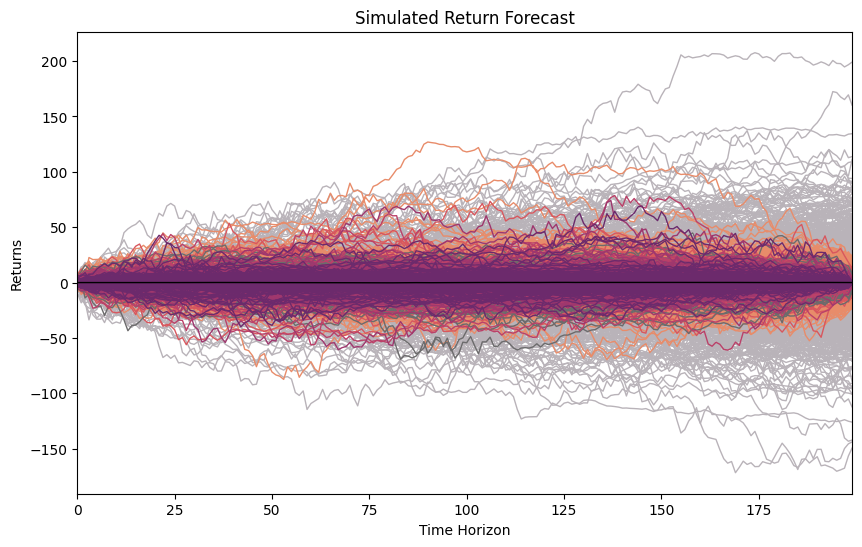

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Simulated Return Forecast'}, xlabel='Time Horizon', ylabel='Returns'>)

In [6]:
from fractrics.utilities import plot_simulation_batch
return_f, _ = MSM.boostrap_forecast(filtered, num_simulation=4000, horizon=200)
plot_simulation_batch(return_f)